# 🤔 Model Selection & Metrics

<img src="https://i.imgur.com/LP6sUuZ.png">

Remember to readdress variance in cross validation

## 🔍 Hyperparameter Search

- Consider a model with $N$ hyperparameters each with $M$ values

    - Hyperparameters should be distinguished from model parameters which are found during training

- There are $M^N$ possible combinations of hyperparamers but only one of them (or more) yields the best metric


- Need to search for that combination. Heuristics include:
    - Brute force search uniformly or randomly over the space (most popular)
    - Use ML engineering skills to focus on only important hyperparameters
        - Includes manual smart search (requires logging)
    - Bayesian optimization (not offered by Scikit-learn)

### Case Study: QDA - Validation Curves

<img src="https://i.imgur.com/xCZlVGw.png">

Machine learning engineering skills suggest that the `reg_param` is the most important hyperparameter since it controls the flexibility of the decision boundary.

#### In cases like these, a validation curve helps!

(100, 5)


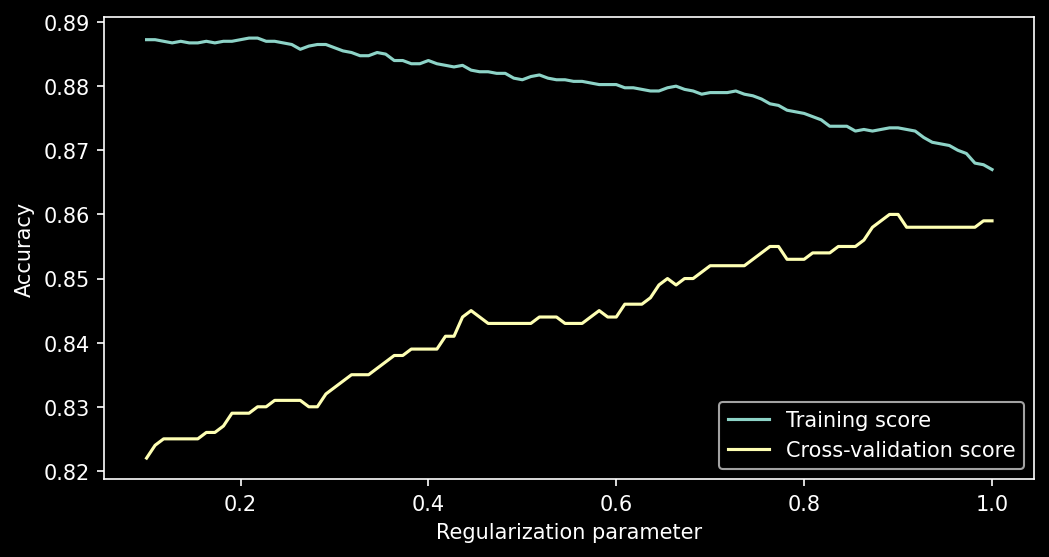

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import validation_curve
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

# Generate a hard classification dataset
x_data, y_data = make_classification(n_samples=1000, n_features=20, n_redundant=0, n_classes=2, random_state=42)

# 0. Initalize a classification model 
clf = QuadraticDiscriminantAnalysis()

# 1. Define the range of values for regularization parameter
reg_params = np.linspace(0.1, 1.0, 100)

# 2. Compute validation scores for different values of reg_param
train_scores, valid_scores = validation_curve(
    clf, x_data, y_data, param_name="reg_param", param_range=reg_params, scoring="accuracy", cv=5)
print(valid_scores.shape)

# 3. Plot
plt.style.use("dark_background")
plt.figure(figsize=(8, 4), dpi=150)
plt.plot(reg_params, np.mean(train_scores, axis=1), label="Training score")
plt.plot(reg_params, np.mean(valid_scores, axis=1), label="Cross-validation score")
plt.xlabel("Regularization parameter")
plt.ylabel("Accuracy")
plt.legend()

Seems like the model was initially overfitting with `reg_param=0`

<br>
Another related curve is the learning curve. Helps answer the following question:

- Would the model improve with more data or is its performance already satured?

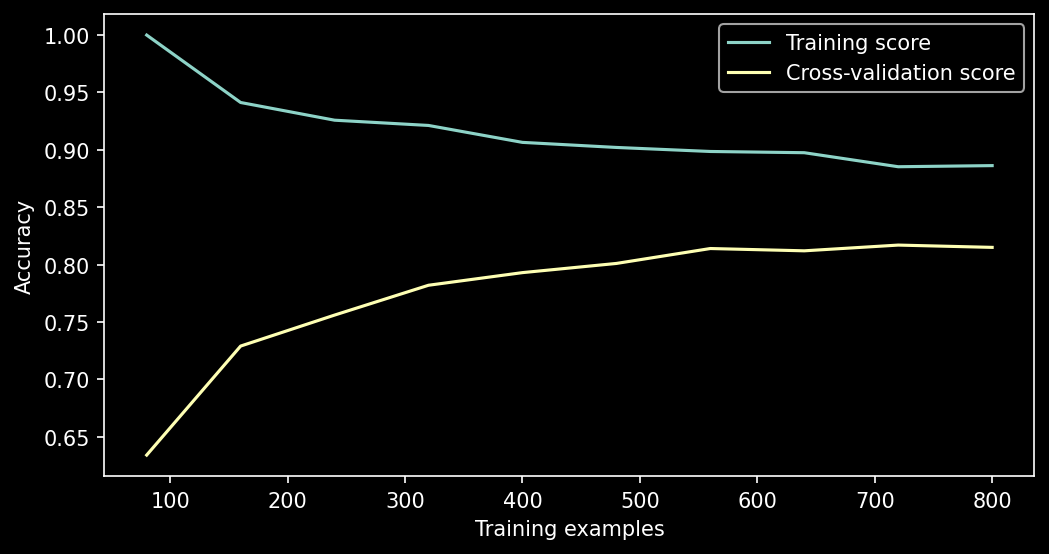

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import learning_curve

# Generate a hard classification dataset
X, y = make_classification(n_samples=1000, n_features=20, n_redundant=0, n_classes=2, random_state=42)

# 0. Initalize a classification model 
clf = QuadraticDiscriminantAnalysis()

# 1. Define training sizes
train_ratios = np.linspace(0.1, 1.0, 10)

# 2. Compute learning curve
train_sizes, train_scores, valid_scores = learning_curve(
    clf, X, y, train_sizes=train_ratios, scoring="accuracy", cv=5,)

plt.style.use("dark_background")
plt.figure(figsize=(8, 4), dpi=150)
plt.plot(train_sizes, np.mean(train_scores, axis=1), label="Training score")
plt.plot(train_sizes, np.mean(valid_scores, axis=1), label="Cross-validation score")
plt.xlabel("Training examples")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

More training data won't likely improve the model.

### Case Study: SVM - Grid and Random Search

<img src="https://i.imgur.com/2GH49jJ.png">

- Too many important variables 

- Validation curve for each misses many important combinations

- Need brute force.

In [3]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.svm import SVC

# Load sample dataset
iris = load_iris()
x_data = iris.data
y_data = iris.target

In [4]:
# 1. Setup parameter distribution (space of combinations)
param_dist = {
    'C': np.logspace(-3, 3, 10),            # from 10^-3 to 10^3
    'gamma': np.logspace(-3, 3, 10),        # from 10^-3 to 10^3
    'kernel': ['linear', 'rbf', 'poly']
}
# Here we consider 10x10x3 combinations

In [5]:
# 2. Initialize Grid/Random Search
clf = SVC()
grid_search = RandomizedSearchCV(clf, param_dist, n_iter=10, cv=5, n_jobs=-1)      

# 3. Fit the data to perform Grid Search
grid_search.fit(X, y)

# Print the best parameters found (ideally, save them locally to load later)
print("Search Done - Best Parameters:", grid_search.best_params_, "Score:", grid_search.best_score_)

Search Done - Best Parameters: {'kernel': 'linear', 'gamma': 215.44346900318823, 'C': 46.41588833612773} Score: 0.861


<img src="https://www.researchgate.net/publication/341691661/figure/fig2/AS:896464364507139@1590745168758/Comparison-between-a-grid-search-and-b-random-search-for-hyper-parameter-tuning-The.png">

- Random search is usually preferred as it considers more unique combination of parameters

- Has an improved version for efficiency `HalvingRandomSearchCV` which starts with a small subset of data and increases it with iterations while discarding the worst half of the parameter space until one parameter set is left

### Case Study: SVM - Hyperparameter Tuning with Logging

- Manual search can be sometimes smarter

- Helps to hyperparameter tune the search methods themselves

- Many packages help with this (e.g., MLFlow, Weights and Biases, MLPath)

In [ ]:
%pip install mlpath

In [24]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report
from mlpath import mlquest as mlq

In [37]:
mlq.start_quest('Scale-Logistic-Pipeline')

#### Data Preperation

In [38]:
# Create custom dataset
X, y = mlq.l(make_classification)(n_samples=5000, n_features=21, random_state=40, n_classes=3, n_informative=6)

# Split the dataset
X_train, X_test, y_train, y_test = mlq.l(train_test_split)(X, y, test_size=0.3, random_state=42)

# Preprocess the data
scaler = mlq.l(StandardScaler)(with_mean=False)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#### Model Training and Prediction

In [39]:
# Create model
model = mlq.l(LogisticRegression)(
    C=15.0,                 # Regularization strength
    solver='newton-cg',    # Optimization algorithm
    random_state=10
)

# Train it
model.fit(X_train_scaled, y_train)

# Step 6: Make predictions on the preprocessed test data
y_pred = model.predict(X_test_scaled)

# Step 7: Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='macro').item()

mlq.log_metrics(accuracy=accuracy, f1=f1)

In [40]:
mlq.end_quest()

mlq.show_logs(last_k=5)         

##### From MLPath Repo:
- Unlike other libraries, MLPath requires minimal boilerplate for tracking and infers hyperparameter names automatically


- Does not restrict developers to using a web interface. Logs can be shown in the notebook itself!


- Less abstraction: Logs can be treated as Pandas tables for additional operations or visualizations


- Comes with MLDir which automatically generates and sets standards for directory structure such as to maximize organization and reproducibility


- MLDir also makes it easier to wrap models that map files to outputs in a web interface

You can contribute to MLPath [here](https://github.com/EssamWisam/MLPath) as a way to get closer to open-source. Example contributions are to make a PR that adds type hints or to make `l` function start a quest automatically with the name of the file if `start_quest` wasn't called apriori instead of the current behaviour (where I make it throw a warning). 

You can also learn more about open-source [here](https://medium.com/nerd-for-tech/diving-deeper-to-crack-gsoc-effaa509d03).

See Bonus.md for the bonus assignment.